# **BitePulse AI - Modeling: RGB 3D CNN vs Hyperband 3D CNN**

* **Name/Group:** Aktham Almomani / Group 13

## **Introduction**


In this notebook we work with RGB clips instead of pose:

* Load window level labels and frame index for the EatSense videos.
* Build a **PyTorch 3D CNN baseline** that takes short RGB clips and predicts intake vs non intake.
* Build a **Keras 3D CNN** and use **Keras Tuner Hyperband** to search over architecture and training hyperparameters.
* Evaluate both models with exactly the same **window level metrics and plots** (confusion matrix, ROC, PR), so we can compare them and with the pose TCN.



In [ ]:
# Mount Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.2 MB/s eta 0:00:00


In [ ]:
import os, sys, math, json, time, random, logging, re
from pathlib import Path
from typing import Dict, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import subprocess, shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import tensorflow as tf
import keras_tuner as kt

from sklearn.metrics import (
    precision_recall_curve, roc_curve, roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef, confusion_matrix, auc,
    classification_report
)

from tqdm.auto import tqdm
from contextlib import nullcontext

plt.rcParams["figure.dpi"] = 120


In [ ]:
POSE_FEATS_PATH = Path("/content/drive/MyDrive/eatsense/windows/pose_feats.parquet")

pose_feats = pd.read_parquet(POSE_FEATS_PATH)
print("pose_feats shape:", pose_feats.shape)
pose_feats.head()

pose_feats shape: (98582, 18)


,key,split,win_id,start_sec,end_sec,label,rw_speed_mean,rw_speed_max,rw_head_min,rw_path,lw_speed_mean,lw_speed_max,lw_head_min,lw_path,re_angle_mean,re_angle_std,le_angle_mean,le_angle_std
0,20210518_230219,train,0,0.0,2.0,0,145.005528,292.955069,16.572304,388.575546,93.775873,240.865456,20.674800,254.556086,156.609365,26.183085,159.404531,13.165441
1,20210518_230219,train,1,0.5,2.5,0,144.750844,292.955069,16.572304,395.191243,86.067394,240.865456,20.674800,242.444187,154.726599,25.178434,156.092829,12.925139
2,20210518_230219,train,2,1.0,3.0,0,115.429775,292.955069,16.572304,326.245907,84.059480,240.865456,20.674800,238.720912,143.522549,28.808757,146.182834,17.691644
3,20210518_230219,train,3,1.5,3.5,0,70.348694,261.323483,44.639644,161.334968,65.090198,173.324211,70.185487,156.761878,132.174230,32.609472,132.567564,22.362200
4,20210518_230219,train,4,2.0,4.0,0,59.101835,261.323483,77.260761,120.857773,55.453864,173.324211,67.433284,111.393292,121.100324,32.854782,118.182391,26.003087


In [ ]:
cols_needed = ["key", "start_sec", "end_sec", "label", "split"]

windows_df = (
    pose_feats[cols_needed]
    .drop_duplicates()
    .reset_index(drop=True)
)

print("windows_df shape:", windows_df.shape)

windows_df["split"].value_counts()

windows_df shape: (98582, 5)


,count
split,
train,62568
val,21184
test,14830


In [ ]:
windows_df.head()

,key,start_sec,end_sec,label,split
0,20210518_230219,0.0,2.0,0,train
1,20210518_230219,0.5,2.5,0,train
2,20210518_230219,1.0,3.0,0,train
3,20210518_230219,1.5,3.5,0,train
4,20210518_230219,2.0,4.0,0,train


## **Extract RGB Frames to Disk**

Scan the EatSense RGB videos, match each labeled `key` to its source clip, and use `ffmpeg` to extract center-cropped 224x224 PNG frames at 15 FPS into `FRAMES_DIR` for the train/val/test splits.


In [ ]:
# Path:
VIDEO_ROOTS = [
    Path("/content/drive/MyDrive/eatsense/rgb/deepfaked")

]

FRAMES_DIR = Path("/content/drive/MyDrive/eatsense/frames")
FRAMES_DIR.mkdir(parents=True, exist_ok=True)

# Splits to process:
SPLITS_TO_PROCESS = {"train", "val", "test"}

# Frame extraction settings:
FPS_TARGET = 15
TARGET_W, TARGET_H = 224, 224  # standard size for 3D-CNN inputs:
VIDEO_EXTS = {".mp4", ".mov", ".mkv", ".avi", ".m4v"}

split_col = windows_df["split"].astype(str).str.lower()
keys_needed = (
    windows_df.loc[split_col.isin(SPLITS_TO_PROCESS), "key"]
    .dropna().astype(str).unique().tolist()
)
print(f"Keys to process: {len(keys_needed)}")

# Index available videos once:
def all_videos_under(roots):
    out = []
    for r in roots:
        if not r.exists():
            continue
        for p in r.rglob("*"):
            if p.is_file() and p.suffix.lower() in VIDEO_EXTS:
                out.append(p)
    return out

videos = all_videos_under(VIDEO_ROOTS)
print(f"Found videos: {len(videos)}")
print("Sample:", [str(v) for v in videos[:3]])

# Heuristic matcher: map each key -> video path:
def match_video_for_key(k: str):
    k_low = k.lower()
    # exact stem match:
    for v in videos:
        if v.stem.lower() == k_low:
            return v
    # relaxed match (containment / prefix):
    for v in videos:
        stem = v.stem.lower()
        if (k_low in stem) or (stem in k_low) or stem.startswith(k_low) or k_low.startswith(stem):
            return v
    return None

key2vid = {k: match_video_for_key(k) for k in keys_needed}
missing = [k for k, v in key2vid.items() if v is None]
print(f"Matched: {sum(v is not None for v in key2vid.values())} | Missing: {len(missing)}")
if missing:
    print("Missing examples (first 10):", missing[:10])

# Extract frames with ffmpeg (fps + center-crop square + resize to TARGET_WxTARGET_H):
def extract_frames(video_path: Path, out_dir: Path, fps: int | None = FPS_TARGET):
    out_dir.mkdir(parents=True, exist_ok=True)
    # Skip if already extracted (has at least one image)
    if any(out_dir.iterdir()):
        return "skip"

    vf = []
    if fps is not None:
        vf.append(f"fps={fps}")
    # center-crop shortest side to square, then high-quality resize:
    vf.append("crop='min(in_w,in_h)':'min(in_w,in_h)'")
    vf.append(f"scale={TARGET_W}:{TARGET_H}:flags=lanczos")

    cmd = [
        "ffmpeg", "-y",
        "-i", str(video_path),
        "-loglevel", "error",
        "-vf", ",".join(vf),
        str(out_dir / "%06d.png"),
    ]
    subprocess.run(cmd, check=True)
    return "ok"

ok, skipped, miss = 0, 0, 0
for k, vid in key2vid.items():
    if vid is None:
        miss += 1
        continue
    out = FRAMES_DIR / k
    try:
        status = extract_frames(vid, out, FPS_TARGET)
        ok += (status == "ok")
        skipped += (status == "skip")
        if status == "ok":
            cnt = sum(1 for _ in out.iterdir())
            print(f"[new] {k}: {cnt} frames -> {out}")
    except Exception as e:
        print(f"[error] {k} <- {vid} :: {e}")

print(f"\nSummary -> new: {ok}, skipped(already there): {skipped}, missing video: {miss}")
print("Frames root:", FRAMES_DIR)


Keys to process: 135
Found videos: 135
Sample: ['/content/drive/MyDrive/eatsense/rgb/deepfaked/20210518_230219_anonymized.mp4', '/content/drive/MyDrive/eatsense/rgb/deepfaked/20210523_202300_anonymized.mp4', '/content/drive/MyDrive/eatsense/rgb/deepfaked/20210529_150552_anonymized.mp4']
Matched: 135 | Missing: 0
[new] 20210518_230219: 3668 frames -> /content/drive/MyDrive/eatsense/frames/20210518_230219
[new] 20210523_202300: 5405 frames -> /content/drive/MyDrive/eatsense/frames/20210523_202300
[new] 20210529_150552: 7502 frames -> /content/drive/MyDrive/eatsense/frames/20210529_150552
[new] 20210529_153708: 1397 frames -> /content/drive/MyDrive/eatsense/frames/20210529_153708
[new] 20210530_153343: 5084 frames -> /content/drive/MyDrive/eatsense/frames/20210530_153343
[new] 20210531_150448: 5475 frames -> /content/drive/MyDrive/eatsense/frames/20210531_150448
[new] 20210603_130948: 7740 frames -> /content/drive/MyDrive/eatsense/frames/20210603_130948
[new] 20210605_155355: 3675 frames 

In [ ]:
test_path = Path("/content/drive/MyDrive/eatsense/frames/20210816_191136/005820.png")
print(test_path, "exists:", test_path.exists())

/content/drive/MyDrive/eatsense/frames/20210816_191136/005820.png exists: True


In [ ]:
FRAMES_DIR = Path("/content/drive/MyDrive/eatsense/frames")

dirs = [p for p in FRAMES_DIR.iterdir() if p.is_dir()]
print("Folders in FRAMES_DIR:", len(dirs))

keys_on_disk   = {d.name for d in dirs}
keys_in_labels = set(keys_needed)

print("Missing on disk:",  keys_in_labels - keys_on_disk)
print("Extra on disk:",    keys_on_disk - keys_in_labels)


Folders in FRAMES_DIR: 135
Missing on disk: set()
Extra on disk: set()


In [ ]:
rows = []
for d in sorted(dirs, key=lambda p: p.name):
    n_png = sum(1 for _ in d.glob("*.png"))
    rows.append({"key": d.name, "n_frames": n_png})

frames_summary = pd.DataFrame(rows)
frames_summary.head()

,key,n_frames
0,20210518_230219,3668
1,20210523_202300,5405
2,20210529_150552,7502
3,20210529_153708,1397
4,20210530_153343,5084


Candidate keys with both classes: 37
Using key: 20210523_202300
Found 5 intake and 5 non-intake windows for key 20210523_202300


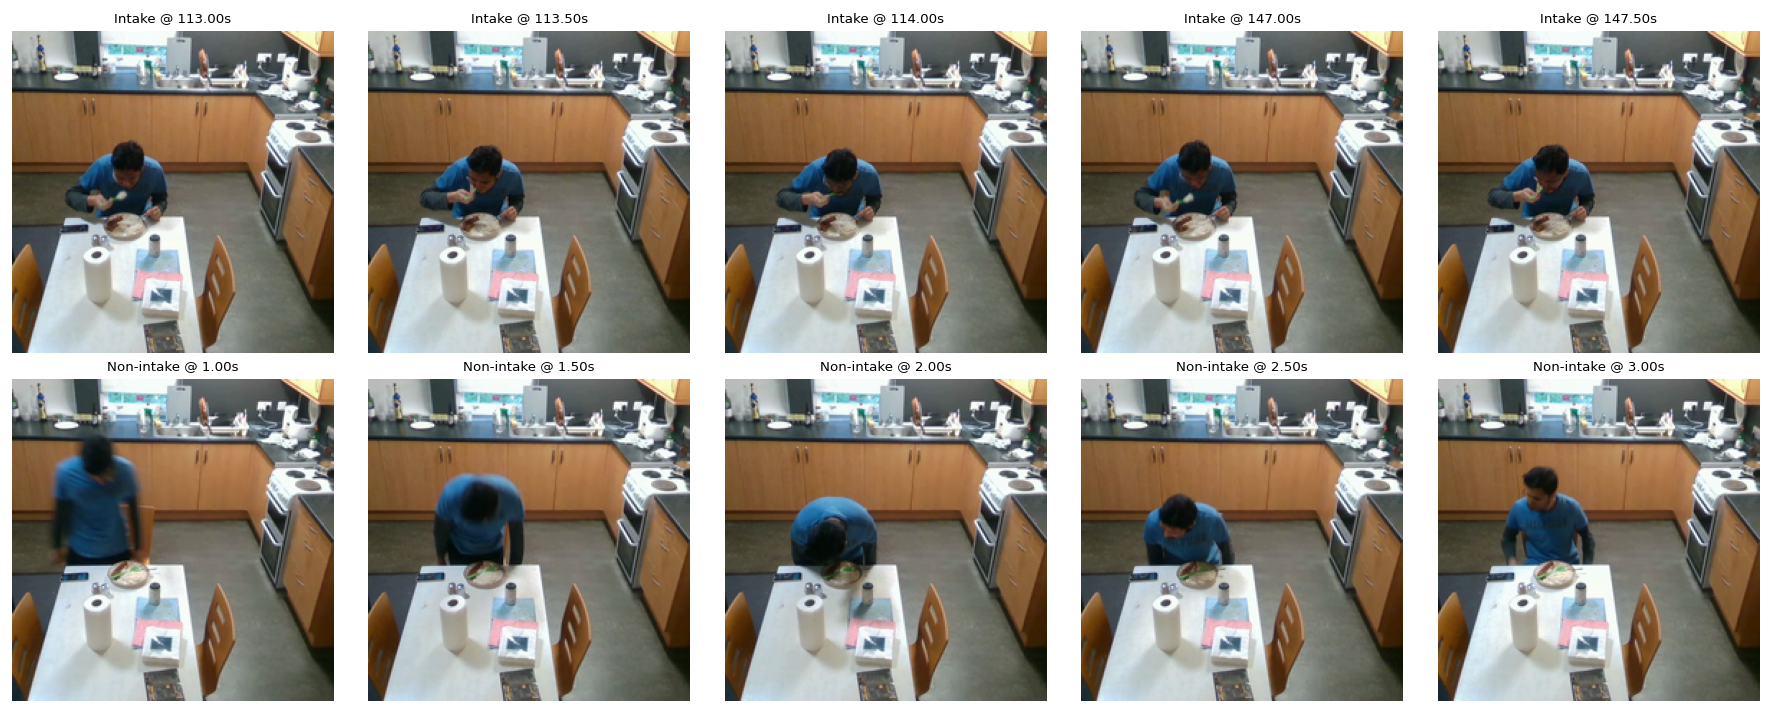

In [ ]:
# Now let's look at few examples to confirm the extrcated frames:
CLIP_FPS = 15.0

# Find keys that have BOTH intake (1) and non-intake (0) windows:
keys_with_pos = set(windows_df.loc[windows_df["label"] == 1, "key"].astype(str))
keys_with_neg = set(windows_df.loc[windows_df["label"] == 0, "key"].astype(str))
candidate_keys = sorted(list(keys_with_pos & keys_with_neg))

print("Candidate keys with both classes:", len(candidate_keys))
if not candidate_keys:
    raise RuntimeError("No key has both intake and non-intake windows.")

key = candidate_keys[0]
print("Using key:", key)

# Helper
def frame_path_for_time(key: str, t_sec: float, fps: float = CLIP_FPS):
    kdir = FRAMES_DIR / str(key)
    files = sorted(kdir.glob("*.png"))
    if not files:
        raise RuntimeError(f"No PNG frames for key={key} in {kdir}")
    n = len(files)
    idx = int(round(t_sec * fps))
    idx = max(0, min(n - 1, idx))
    return files[idx]

# Filter windows for this key and select 5 intake + 5 non-intake:
df_key = windows_df[windows_df["key"].astype(str) == key].copy()

pos_rows = df_key[df_key["label"] == 1].head(5)
neg_rows = df_key[df_key["label"] == 0].head(5)

print(f"Found {len(pos_rows)} intake and {len(neg_rows)} non-intake windows for key {key}")

if len(pos_rows) < 5 or len(neg_rows) < 5:
    raise RuntimeError("Not enough intake or non-intake windows (need at least 5 of each).")

# Collect images:
img_infos = []  # list of (PIL.Image, title)

# First 5 intake:
for _, r in pos_rows.iterrows():
    t_mid = (float(r["start_sec"]) + float(r["end_sec"])) / 2.0
    p = frame_path_for_time(key, t_mid)
    img = Image.open(p).convert("RGB")
    img_infos.append((img, f"Intake @ {t_mid:.2f}s"))

# Then 5 non-intake:
for _, r in neg_rows.iterrows():
    t_mid = (float(r["start_sec"]) + float(r["end_sec"])) / 2.0
    p = frame_path_for_time(key, t_mid)
    img = Image.open(p).convert("RGB")
    img_infos.append((img, f"Non-intake @ {t_mid:.2f}s"))

# Plot as 2 rows x 5 columns:
rows, cols = 2, 5
n_imgs = len(img_infos)
assert n_imgs == rows * cols, f"Expected 10 images, got {n_imgs}"

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

for idx, (img, title) in enumerate(img_infos):
    r = idx // cols
    c = idx % cols
    ax = axes[r, c]
    ax.imshow(img)
    ax.set_title(title, fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()


## **Baseline RGB 3D-CNN Modeling**

In [ ]:
# Ste up configuration:


ROOT       = Path("/content/drive/MyDrive/eatsense")
LABELS_DIR = ROOT / "labels_v1"
FRAMES_DIR = ROOT / "frames"
CKPT_DIR   = ROOT / "checkpoints_rgb"
LOG_DIR    = ROOT / "logs_rgb"

IMG_EXT   = ".png"
FRAME_PAD = 6

for d in [CKPT_DIR, LOG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

CONFIG: Dict[str, Any] = {
    "seed": 1981,
    "num_workers": 2,
    "pin_memory": True,
    "persistent_workers": True,
    # training
    "epochs": 10,
    "batch_size": 8,
    "lr": 3e-4,
    "weight_decay": 1e-5,
    "pos_class_weight": 2.0,   # BCE pos_weight
    "amp": True,
    "amp_dtype": "bf16",       # "bf16" or "fp16"
    # RGB clip settings
    "clip_len": 16,            # frames per window
    "img_size": 112,           # 112x112 input to 3D CNN
}

def set_seed(seed: int = 1981):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG["seed"])

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE.type} | Torch: {torch.__version__}")

def get_logger(name="bitepulse_rgb",
               level=logging.INFO,
               log_file: Optional[Path] = LOG_DIR / "run_rgb3d.log"):
    logger = logging.getLogger(name)
    if logger.handlers:
        return logger
    logger.setLevel(level)
    fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")
    sh = logging.StreamHandler(stream=sys.stdout)
    sh.setFormatter(fmt)
    logger.addHandler(sh)
    if log_file:
        fh = logging.FileHandler(log_file)
        fh.setFormatter(fmt)
        logger.addHandler(fh)
    return logger

LOGGER = get_logger()

def make_amp_ctx():
    if not CONFIG["amp"] or DEVICE.type != "cuda":
        return nullcontext
    if CONFIG.get("amp_dtype", "bf16") == "bf16":
        return lambda: torch.amp.autocast("cuda", dtype=torch.bfloat16)
    else:
        return lambda: torch.amp.autocast("cuda", dtype=torch.float16)

AMP_CTX = make_amp_ctx()

SCALER = (
    torch.amp.GradScaler("cuda")
    if (CONFIG["amp"] and CONFIG.get("amp_dtype") == "fp16" and DEVICE.type == "cuda")
    else None
)


Device: cuda | Torch: 2.9.0+cu126


In [ ]:
# Alright now let's load window table and frame index:


MANIFEST_PATH   = LABELS_DIR / "manifest_with_split.parquet"
FRAMES_IDX_PATH = LABELS_DIR / "frames_idx.parquet"
WINDOWS_PATH    = ROOT / "logs" / "windows_idx.parquet"

assert FRAMES_IDX_PATH.exists(), FRAMES_IDX_PATH
assert WINDOWS_PATH.exists(), WINDOWS_PATH

frames_ix  = pd.read_parquet(FRAMES_IDX_PATH)
windows_df = pd.read_parquet(WINDOWS_PATH)

if "time_sec" not in frames_ix.columns and {"frame", "fps"}.issubset(frames_ix.columns):
    frames_ix = frames_ix.copy()
    frames_ix["time_sec"] = frames_ix["frame"] / frames_ix["fps"]

assert "time_sec" in frames_ix.columns, "frames_idx needs 'time_sec' column"

print("windows_df:", windows_df.shape)
print("frames_ix :", frames_ix.shape)

# class balance by split:
print("\nLabel distribution by split:")
print(
    windows_df.groupby("split")["label"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0.0)
)


windows_df: (98582, 5)
frames_ix : (742887, 5)

Label distribution by split:
label         0         1
split                    
test   0.993999  0.006001
train  0.993255  0.006745
val    0.997309  0.002691


In [ ]:
# Checking that keys in windows appear in frames_ix:
win_keys = set(windows_df["key"].astype(str))
frame_keys = set(frames_ix["key"].astype(str))
missing_keys = sorted(win_keys - frame_keys)
print(f"Unique keys in windows: {len(win_keys)}")
print(f"Unique keys in frames : {len(frame_keys)}")
print(f"Windows keys missing in frames_ix: {len(missing_keys)}")
if missing_keys:
    print("Example missing keys:", missing_keys[:10])


Unique keys in windows: 135
Unique keys in frames : 135
Windows keys missing in frames_ix: 0


In [ ]:
# Now let's setup metric helpers and evaluation (similar to TCN)

def bin_metrics_from_logits_np(logits: np.ndarray,
                               targets: np.ndarray,
                               thr: float = 0.5):
    probs = 1.0 / (1.0 + np.exp(-logits))
    preds = (probs >= thr).astype(int)
    y     = targets.astype(int)

    tp = int(((preds == 1) & (y == 1)).sum())
    fp = int(((preds == 1) & (y == 0)).sum())
    fn = int(((preds == 0) & (y == 1)).sum())
    tn = int(((preds == 0) & (y == 0)).sum())

    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    acc  = (tp + tn) / (tp + tn + fp + fn + 1e-9)
    f1   = 2 * prec * rec / (prec + rec + 1e-9)

    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1,
            "tp": tp, "fp": fp, "fn": fn, "tn": tn}


def best_f1_threshold_with_floor(
    logits: np.ndarray,
    targets: np.ndarray,
    prec_floor: float = 0.10,
    rec_floor: float  = 0.10,
):
    y_true = targets.astype(int)
    probs  = 1.0 / (1.0 + np.exp(-logits.astype(np.float64)))
    P, R, T = precision_recall_curve(y_true, probs)

    best_f1, best_thr = 0.0, 0.5
    best_tuple = (0.0, 0.0, 0, 0, 0)

    for p, r, t in zip(P[:-1], R[:-1], T):
        if (p < prec_floor) or (r < rec_floor):
            continue
        f1 = 2 * p * r / (p + r + 1e-12)
        if f1 > best_f1:
            thr = float(t)
            preds = (probs >= thr).astype(int)
            tp = int(((preds==1) & (y_true==1)).sum())
            fp = int(((preds==1) & (y_true==0)).sum())
            fn = int(((preds==0) & (y_true==1)).sum())
            best_f1, best_thr = f1, thr
            best_tuple = (p, r, tp, fp, fn)

    return best_f1, best_thr, best_tuple


def evaluate_window_model(logits_np: np.ndarray,
                          targets_np: np.ndarray,
                          label: str,
                          prec_floor: float = 0.10,
                          rec_floor: float = 0.10):
    y_true = targets_np.astype(int)
    f1_star, thr_star, _ = best_f1_threshold_with_floor(
        logits_np, y_true,
        prec_floor=prec_floor,
        rec_floor=rec_floor,
    )
    thr = float(thr_star)
    p_prob = 1.0 / (1.0 + np.exp(-logits_np.astype(np.float64)))
    y_pred = (p_prob >= thr).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn / (tn + fp + 1e-12)

    metrics = {
        "threshold(F1*)": thr,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "specificity": spec,
        "balanced_acc": balanced_accuracy_score(y_true, y_pred),
        "mcc": matthews_corrcoef(y_true, y_pred),
        "roc_auc_overall": roc_auc_score(y_true, p_prob),
        "pr_auc_overall": average_precision_score(y_true, p_prob),
    }

    print(f"\n=== {label}: metrics @ best F1 threshold ===")
    for k, v in metrics.items():
        if isinstance(v, float):
            print(f"{k:>20s}: {v:0.3f}")
        else:
            print(f"{k:>20s}: {v}")

    print("\nConfusion Matrix (rows=actual, cols=pred):")
    print(np.array([[tn, fp], [fn, tp]]))
    print("\nClassification report:\n",
          classification_report(y_true, y_pred, digits=3, zero_division=0))

    fig = plt.figure(figsize=(12, 4))

    cm = np.array([[tn, fp], [fn, tp]], dtype=float)
    cm_norm = cm / cm.sum(axis=1, keepdims=True).clip(1)

    ax1 = plt.subplot(1, 3, 1)
    im = ax1.imshow(cm_norm, vmin=0, vmax=1)
    ax1.set_title(f"{label} – Confusion @ thr={thr:.2f}")
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
    ax1.set_xticks([0, 1]); ax1.set_xticklabels(["Not intake", "Intake"])
    ax1.set_yticks([0, 1]); ax1.set_yticklabels(["Not intake", "Intake"])
    for i in range(2):
        for j in range(2):
            ax1.text(j, i, f"{int(cm[i,j])}\n({cm_norm[i,j]*100:.1f}%)",
                     ha="center", va="center",
                     color="white" if cm_norm[i,j] > 0.5 else "black",
                     fontsize=9)
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

    fpr, tpr, _ = roc_curve(y_true, p_prob)
    ax2 = plt.subplot(1, 3, 2)
    ax2.plot(fpr, tpr, label=f"AUC = {metrics['roc_auc_overall']:.3f}")
    ax2.plot([0, 1], [0, 1], "--", linewidth=1)
    ax2.set_title(f"{label} – ROC")
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="lower right")

    P, R, _ = precision_recall_curve(y_true, p_prob)
    ax3 = plt.subplot(1, 3, 3)
    ax3.plot(R, P, label=f"AP = {metrics['pr_auc_overall']:.3f}")
    ax3.set_title(f"{label} – Precision Recall")
    ax3.set_xlabel("Recall")
    ax3.set_ylabel("Precision")
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

    return {"metrics": metrics, "thr": thr, "probs": p_prob, "y_true": y_true}


In [ ]:
# Fixed RGB dataset + DataLoaders

IMG_EXT   = ".png"
FRAME_PAD = 6
CLIP_FPS  = float(FPS_TARGET) if "FPS_TARGET" in globals() else 15.0

class RGBWindowDataset(Dataset):
    """
    Each item is an RGB clip for a labeled window.
    x: (T, 3, H, W) in [0,1], y: scalar float32 (0 or 1).

    For each key we:
      1) List all PNG frames actually on disk.
      2) Map window times [w0, w1) to frame indices via CLIP_FPS.
      3) Clamp indices into [0, n_frames-1] so we never hit a missing file.
    """
    def __init__(self,
                 windows: pd.DataFrame,
                 clip_len: int = 16,
                 img_size: int = 112,
                 fps: float = CLIP_FPS):
        self.df       = windows.reset_index(drop=True)
        self.clip_len = int(clip_len)
        self.img_size = int(img_size)
        self.fps      = float(fps)

    def _load_clip(self, key: str, w0: float, w1: float):
        key = str(key)
        kdir = FRAMES_DIR / key
        files = sorted(kdir.glob(f"*{IMG_EXT}"))

        if not files:
            raise RuntimeError(f"No frame files found for key={key} in {kdir}")

        n_frames = len(files)

        #
        times = np.linspace(w0, w1, num=self.clip_len, endpoint=False)

        frames = []
        for t in times:

            idx = int(round(t * self.fps))
            idx = max(0, min(n_frames - 1, idx))
            path = files[idx]

            img = Image.open(path).convert("RGB")
            img = img.resize((self.img_size, self.img_size))
            x = np.asarray(img, dtype=np.float32) / 255.0
            x = np.transpose(x, (2, 0, 1))
            frames.append(x)

        arr = np.stack(frames, axis=0)
        return arr.astype(np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i: int):
        r = self.df.iloc[i]
        key   = r["key"]
        w0    = float(r["start_sec"])
        w1    = float(r["end_sec"])
        label = float(r["label"])

        clip = self._load_clip(key, w0, w1)
        x    = torch.from_numpy(clip)
        y    = torch.tensor(label, dtype=torch.float32)
        return x, y


def make_rgb_loader(windows_df, split: str, balance: bool = True):
    # take split:
    df_split = windows_df[windows_df["split"] == split].reset_index(drop=True)

    # PNGs location:
    keys_with_frames = []
    for p in FRAMES_DIR.iterdir():
        if p.is_dir() and any(p.glob(f"*{IMG_EXT}")):
            keys_with_frames.append(p.name)
    keys_with_frames = set(keys_with_frames)

    # filter windows:
    mask = df_split["key"].astype(str).isin(keys_with_frames)
    n_before = len(df_split)
    df_split = df_split[mask].reset_index(drop=True)
    n_after = len(df_split)
    print(f"[{split}] windows with frames: {n_after}/{n_before} "
          f"(dropped {n_before - n_after})")

    # dataset:
    ds = RGBWindowDataset(
        df_split,
        clip_len=CONFIG["clip_len"],
        img_size=CONFIG["img_size"],
        fps=CLIP_FPS,
    )

    # class balancing:
    if balance and split == "train":
        labels = ds.df["label"].astype(int).values
        counts = np.bincount(labels, minlength=2).astype(np.float32)
        weights = 1.0 / (counts[labels] + 1e-9)
        sampler = WeightedRandomSampler(
            weights.tolist(),
            num_samples=len(weights),
            replacement=True,
        )
        shuffle = False
    else:
        sampler = None
        shuffle = (split == "train")

    loader = DataLoader(
        ds,
        batch_size=CONFIG["batch_size"],
        shuffle=shuffle if sampler is None else False,
        sampler=sampler,
        num_workers=CONFIG["num_workers"],
        pin_memory=CONFIG["pin_memory"],
        persistent_workers=CONFIG["persistent_workers"] if CONFIG["num_workers"] > 0 else False,
        drop_last=False,
    )
    return loader, ds


# Loaders:
train_rgb_loader, train_rgb_ds = make_rgb_loader(windows_df, "train", balance=True)
val_rgb_loader,   val_rgb_ds   = make_rgb_loader(windows_df, "val",   balance=False)

# Sanity check:
clip, label = train_rgb_ds[0]
print("Single clip shape:", clip.shape, "label:", label)
print("clip stats: min", float(clip.min()),
      "max", float(clip.max()),
      "mean", float(clip.mean()),
      "std", float(clip.std()))

batch_x, batch_y = next(iter(train_rgb_loader))
print("Batch shape:", batch_x.shape)   # expect (B,T,3,112,112)
print("Batch stats:",
      float(batch_x.min()),
      float(batch_x.max()),
      float(batch_x.mean()),
      float(batch_x.std()))


[train] windows with frames: 7268/62568 (dropped 55300)
[val] windows with frames: 2565/21184 (dropped 18619)
Single clip shape: torch.Size([16, 3, 112, 112]) label: tensor(0.)
clip stats: min 0.0 max 1.0 mean 0.45068100094795227 std 0.24670635163784027
Batch shape: torch.Size([8, 16, 3, 112, 112])
Batch stats: 0.0 1.0 0.47496291995048523 0.25107431411743164


## **Baseline PyTorch 3D CNN - Training**

In [ ]:
class RGB3DNet(nn.Module):
    """
    3D CNN for RGB clips.
    Input:  x (B, T, 3, H, W)
    Output: logits of shape (B,) for intake vs non-intake.
    """
    def __init__(self):
        super().__init__()
        # we'll permute to (B, 3, T, H, W) in forward
        self.features = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=(3, 7, 7),
                      stride=(1, 2, 2), padding=(1, 3, 3), bias=False),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 3, 3),
                         stride=(1, 2, 2), padding=(0, 1, 1)),

            nn.Conv3d(32, 64, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2),
                         stride=(2, 2, 2)),

            nn.Conv3d(64, 128, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2),
                         stride=(2, 2, 2)),
        )

        self.pool = nn.AdaptiveAvgPool3d(1)   # (B, C, 1, 1, 1)
        self.fc   = nn.Linear(128, 1)

    def forward(self, x):
        # x: (B, T, 3, H, W) -> (B, 3, T, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.fc(x)
        return x.squeeze(-1)   # (B,)


def run_rgb_epoch(model, loader, optimizer=None):
    """
    One pass over a DataLoader.
    If optimizer is None -> eval mode, no grads.
    Returns: avg_loss, metrics_dict, logits_np, targets_np
    """
    train_mode = optimizer is not None
    model.train(train_mode)

    pos_w = torch.tensor(
        [CONFIG.get("pos_class_weight", 1.0)],
        device=DEVICE, dtype=torch.float32,
    )
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w)

    total_loss, n_seen = 0.0, 0
    all_logits, all_targets = [], []

    for x, y in tqdm(loader, desc="batches", leave=False):
        # x: (B,T,3,H,W), y: scalar {0,1}
        x = x.to(DEVICE, non_blocking=True).float()
        y = y.to(DEVICE, non_blocking=True).float()  # (B,)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)

        with AMP_CTX():
            logits = model(x)            # (B,)
            loss   = criterion(logits, y)

        if train_mode:
            loss.backward()
            optimizer.step()

        bs = x.size(0)
        total_loss += float(loss.item()) * bs
        n_seen     += bs

        all_logits.append(logits.detach().cpu())
        all_targets.append(y.detach().cpu())

    # ---- FIX: cast bfloat16 -> float32 before converting to NumPy ----
    if len(all_logits) == 0:
        return 0.0, {"acc": 0, "prec": 0, "rec": 0, "f1": 0}, np.array([]), np.array([])

    logits_cat  = torch.cat(all_logits, dim=0).to(torch.float32)
    targets_cat = torch.cat(all_targets, dim=0).to(torch.float32)

    logits_np  = logits_cat.numpy()
    targets_np = targets_cat.numpy().astype(int)

    metrics = bin_metrics_from_logits_np(logits_np, targets_np, thr=0.5)

    return total_loss / max(1, n_seen), metrics, logits_np, targets_np



def train_rgb3d(train_loader, val_loader):
    model = RGB3DNet().to(DEVICE)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG["lr"],
        weight_decay=CONFIG["weight_decay"],
    )

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=8e-4,
        steps_per_epoch=len(train_loader),
        epochs=CONFIG["epochs"],
    )

    best_val_f1 = -1.0
    best_state  = None

    for epoch in range(CONFIG["epochs"]):
        LOGGER.info(f"[RGB3D] epoch {epoch+1}/{CONFIG['epochs']}")

        tr_loss, tr_m, _, _ = run_rgb_epoch(model, train_loader,
                                            optimizer=optimizer)
        try:
            scheduler.step()
        except Exception:
            pass

        va_loss, va_m, va_logits_np, va_y_np = run_rgb_epoch(
            model, val_loader, optimizer=None
        )

        f1_star, thr_star, _ = best_f1_threshold_with_floor(
            va_logits_np, va_y_np
        )

        LOGGER.info(
            f"train loss {tr_loss:.4f} | "
            f"acc {tr_m['acc']:.3f} prec {tr_m['prec']:.3f} "
            f"rec {tr_m['rec']:.3f} f1 {tr_m['f1']:.3f}"
        )
        LOGGER.info(
            f" val  loss {va_loss:.4f} | best_f1 {f1_star:.3f} "
            f"thr {thr_star:.2f}"
        )

        if f1_star > best_val_f1:
            best_val_f1 = f1_star
            best_state = {
                "model": model.state_dict(),
                "val_f1": float(best_val_f1),
                "best_thr": float(thr_star),
            }
            torch.save(best_state, CKPT_DIR / "rgb3d_best.pt")
            LOGGER.info(
                f"✓ saved new best (f1={best_val_f1:.3f} @ thr={thr_star:.2f})"
            )

    LOGGER.info(f"[RGB3D] best val f1={best_val_f1:.3f}")
    return model


model_rgb3d = train_rgb3d(train_rgb_loader, val_rgb_loader)


2025-11-27 20:34:21,125 | INFO | [RGB3D] epoch 1/10


INFO:bitepulse_rgb:[RGB3D] epoch 1/10


batches:   0%|          | 0/909 [00:35<?, ?it/s]

batches:   0%|          | 0/321 [00:00<?, ?it/s]

2025-11-27 21:54:39,647 | INFO | train loss 0.4772 | acc 0.816 prec 0.751 rec 0.952 f1 0.839


INFO:bitepulse_rgb:train loss 0.4772 | acc 0.816 prec 0.751 rec 0.952 f1 0.839


2025-11-27 21:54:39,649 | INFO |  val  loss 0.7800 | best_f1 0.134 thr 0.73


INFO:bitepulse_rgb: val  loss 0.7800 | best_f1 0.134 thr 0.73


2025-11-27 21:54:40,498 | INFO | ✓ saved new best (f1=0.134 @ thr=0.73)


INFO:bitepulse_rgb:✓ saved new best (f1=0.134 @ thr=0.73)


2025-11-27 21:54:40,500 | INFO | [RGB3D] epoch 2/10


INFO:bitepulse_rgb:[RGB3D] epoch 2/10


batches:   0%|          | 0/909 [00:00<?, ?it/s]

batches:   0%|          | 0/321 [00:00<?, ?it/s]

2025-11-27 22:33:00,060 | INFO | train loss 0.3072 | acc 0.903 prec 0.855 rec 0.973 f1 0.910


INFO:bitepulse_rgb:train loss 0.3072 | acc 0.903 prec 0.855 rec 0.973 f1 0.910


2025-11-27 22:33:00,062 | INFO |  val  loss 0.3229 | best_f1 0.188 thr 0.56


INFO:bitepulse_rgb: val  loss 0.3229 | best_f1 0.188 thr 0.56


2025-11-27 22:33:00,073 | INFO | ✓ saved new best (f1=0.188 @ thr=0.56)


INFO:bitepulse_rgb:✓ saved new best (f1=0.188 @ thr=0.56)


2025-11-27 22:33:00,074 | INFO | [RGB3D] epoch 3/10


INFO:bitepulse_rgb:[RGB3D] epoch 3/10


batches:   0%|          | 0/909 [00:00<?, ?it/s]

batches:   0%|          | 0/321 [00:00<?, ?it/s]

2025-11-27 23:09:23,452 | INFO | train loss 0.2176 | acc 0.941 prec 0.902 rec 0.991 f1 0.944


INFO:bitepulse_rgb:train loss 0.2176 | acc 0.941 prec 0.902 rec 0.991 f1 0.944


2025-11-27 23:09:23,454 | INFO |  val  loss 0.1337 | best_f1 0.186 thr 0.03


INFO:bitepulse_rgb: val  loss 0.1337 | best_f1 0.186 thr 0.03


2025-11-27 23:09:23,455 | INFO | [RGB3D] epoch 4/10


INFO:bitepulse_rgb:[RGB3D] epoch 4/10


batches:   0%|          | 0/909 [00:00<?, ?it/s]

batches:   0%|          | 0/321 [00:00<?, ?it/s]

2025-11-27 23:45:05,509 | INFO | train loss 0.1597 | acc 0.966 prec 0.943 rec 0.992 f1 0.967


INFO:bitepulse_rgb:train loss 0.1597 | acc 0.966 prec 0.943 rec 0.992 f1 0.967


2025-11-27 23:45:05,510 | INFO |  val  loss 3.3173 | best_f1 0.163 thr 1.00


INFO:bitepulse_rgb: val  loss 3.3173 | best_f1 0.163 thr 1.00


2025-11-27 23:45:05,512 | INFO | [RGB3D] epoch 5/10


INFO:bitepulse_rgb:[RGB3D] epoch 5/10


batches:   0%|          | 0/909 [00:00<?, ?it/s]

batches:   0%|          | 0/321 [00:00<?, ?it/s]

2025-11-28 00:21:16,923 | INFO | train loss 0.1284 | acc 0.978 prec 0.960 rec 0.997 f1 0.978


INFO:bitepulse_rgb:train loss 0.1284 | acc 0.978 prec 0.960 rec 0.997 f1 0.978


2025-11-28 00:21:16,924 | INFO |  val  loss 0.2908 | best_f1 0.137 thr 0.65


INFO:bitepulse_rgb: val  loss 0.2908 | best_f1 0.137 thr 0.65


2025-11-28 00:21:16,926 | INFO | [RGB3D] epoch 6/10


INFO:bitepulse_rgb:[RGB3D] epoch 6/10


batches:   0%|          | 0/909 [00:00<?, ?it/s]

batches:   0%|          | 0/321 [00:00<?, ?it/s]

2025-11-28 00:56:34,979 | INFO | train loss 0.1022 | acc 0.984 prec 0.969 rec 0.999 f1 0.984


INFO:bitepulse_rgb:train loss 0.1022 | acc 0.984 prec 0.969 rec 0.999 f1 0.984


2025-11-28 00:56:34,980 | INFO |  val  loss 0.1300 | best_f1 0.153 thr 0.15


INFO:bitepulse_rgb: val  loss 0.1300 | best_f1 0.153 thr 0.15


2025-11-28 00:56:34,981 | INFO | [RGB3D] epoch 7/10


INFO:bitepulse_rgb:[RGB3D] epoch 7/10


batches:   0%|          | 0/909 [00:00<?, ?it/s]

batches:   0%|          | 0/321 [00:00<?, ?it/s]

2025-11-28 01:31:01,353 | INFO | train loss 0.0903 | acc 0.984 prec 0.971 rec 0.998 f1 0.984


INFO:bitepulse_rgb:train loss 0.0903 | acc 0.984 prec 0.971 rec 0.998 f1 0.984


2025-11-28 01:31:01,354 | INFO |  val  loss 0.1369 | best_f1 0.161 thr 0.17


INFO:bitepulse_rgb: val  loss 0.1369 | best_f1 0.161 thr 0.17


2025-11-28 01:31:01,355 | INFO | [RGB3D] epoch 8/10


INFO:bitepulse_rgb:[RGB3D] epoch 8/10


batches:   0%|          | 0/909 [00:00<?, ?it/s]

batches:   0%|          | 0/321 [00:00<?, ?it/s]

2025-11-28 02:06:02,741 | INFO | train loss 0.0801 | acc 0.984 prec 0.970 rec 0.998 f1 0.984


INFO:bitepulse_rgb:train loss 0.0801 | acc 0.984 prec 0.970 rec 0.998 f1 0.984


2025-11-28 02:06:02,742 | INFO |  val  loss 1.4249 | best_f1 0.000 thr 0.50


INFO:bitepulse_rgb: val  loss 1.4249 | best_f1 0.000 thr 0.50


2025-11-28 02:06:02,743 | INFO | [RGB3D] epoch 9/10


INFO:bitepulse_rgb:[RGB3D] epoch 9/10


batches:   0%|          | 0/909 [00:00<?, ?it/s]

batches:   0%|          | 0/321 [00:00<?, ?it/s]

2025-11-28 02:41:38,777 | INFO | train loss 0.0639 | acc 0.989 prec 0.978 rec 1.000 f1 0.989


INFO:bitepulse_rgb:train loss 0.0639 | acc 0.989 prec 0.978 rec 1.000 f1 0.989


2025-11-28 02:41:38,778 | INFO |  val  loss 0.1281 | best_f1 0.175 thr 0.17


INFO:bitepulse_rgb: val  loss 0.1281 | best_f1 0.175 thr 0.17


2025-11-28 02:41:38,779 | INFO | [RGB3D] epoch 10/10


INFO:bitepulse_rgb:[RGB3D] epoch 10/10


batches:   0%|          | 0/909 [00:00<?, ?it/s]

batches:   0%|          | 0/321 [00:00<?, ?it/s]

2025-11-28 03:18:21,930 | INFO | train loss 0.0604 | acc 0.989 prec 0.979 rec 1.000 f1 0.989


INFO:bitepulse_rgb:train loss 0.0604 | acc 0.989 prec 0.979 rec 1.000 f1 0.989


2025-11-28 03:18:21,931 | INFO |  val  loss 0.1285 | best_f1 0.174 thr 0.12


INFO:bitepulse_rgb: val  loss 0.1285 | best_f1 0.174 thr 0.12


2025-11-28 03:18:21,933 | INFO | [RGB3D] best val f1=0.188


INFO:bitepulse_rgb:[RGB3D] best val f1=0.188


### **Baseline PyTorch 3D CNN - Performance Evaluation**

In [ ]:
best_ckpt_path = CKPT_DIR / "rgb3d_best.pt"
print("Checkpoint:", best_ckpt_path, "| exists:", best_ckpt_path.exists())

ckpt = torch.load(best_ckpt_path, map_location=DEVICE)

model_rgb3d_best = RGB3DNet().to(DEVICE)
model_rgb3d_best.load_state_dict(ckpt["model"])
model_rgb3d_best.eval()

print(f"Best val F1 (saved in ckpt): {ckpt.get('val_f1', None)}  @ thr={ckpt.get('best_thr', None)}")


Checkpoint: /content/drive/MyDrive/eatsense/checkpoints_rgb/rgb3d_best.pt | exists: True
Best val F1 (saved in ckpt): 0.18803418803373279  @ thr=0.5640984800226174


In [ ]:
# Best checkpoint model:
val_loss_rgb, val_m_rgb, val_logits_rgb, val_y_rgb = run_rgb_epoch(
    model_rgb3d_best,
    val_rgb_loader,
    optimizer=None,
)

print("=== RGB3D baseline: quick val metrics @ thr=0.5 ===")
for k, v in val_m_rgb.items():
    print(f"{k:>10s}: {v:.3f}")
print("val_loss:", val_loss_rgb)


batches:   0%|          | 0/321 [00:00<?, ?it/s]

=== RGB3D baseline: quick val metrics @ thr=0.5 ===
       acc: 0.948
      prec: 0.122
       rec: 0.366
        f1: 0.183
        tp: 15.000
        fp: 108.000
        fn: 26.000
        tn: 2416.000
val_loss: 0.32293026334593405



=== PyTorch RGB3D (baseline): metrics @ best F1 threshold ===
      threshold(F1*): 0.564
            accuracy: 0.963
           precision: 0.145
              recall: 0.268
                  f1: 0.188
         specificity: 0.974
        balanced_acc: 0.621
                 mcc: 0.179
     roc_auc_overall: 0.733
      pr_auc_overall: 0.095

Confusion Matrix (rows=actual, cols=pred):
[[2459   65]
 [  30   11]]

Classification report:
               precision    recall  f1-score   support

           0      0.988     0.974     0.981      2524
           1      0.145     0.268     0.188        41

    accuracy                          0.963      2565
   macro avg      0.566     0.621     0.585      2565
weighted avg      0.974     0.963     0.968      2565



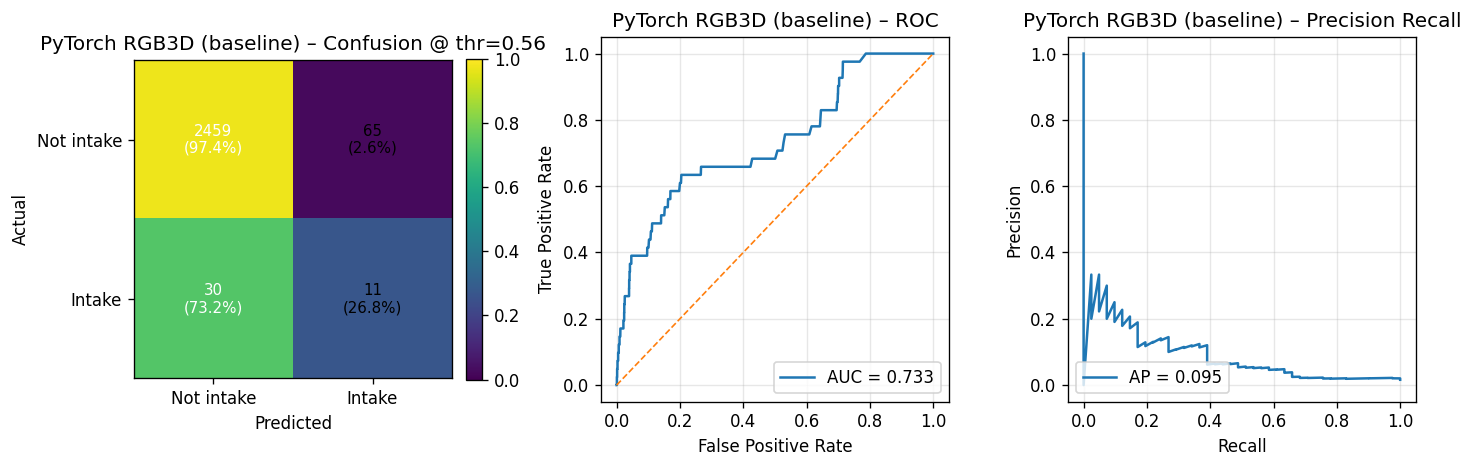

In [ ]:
rgb3d_eval = evaluate_window_model(
    logits_np  = val_logits_rgb,
    targets_np = val_y_rgb,
    label      = "PyTorch RGB3D (baseline)",
    prec_floor = 0.10,
    rec_floor  = 0.10,
)


### **3D-CNN - hyperband Search**

In [ ]:
# TF GPU config:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass
print("TF GPUs:", gpus)



TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import math

class RGBWindowSequence(tf.keras.utils.Sequence):
    """
    Keras data generator: yields (X, y) batches for window-level RGB clips.

    X shape: (B, T, H, W, 3) in [0,1]
    y shape: (B, 1) float32 {0,1}
    """
    def __init__(self,
                 windows: pd.DataFrame,
                 batch_size: int = 4,
                 clip_len: int = 16,
                 img_size: int = 112,
                 fps: float = CLIP_FPS):
        self.df         = windows.reset_index(drop=True)
        self.batch_size = int(batch_size)
        self.clip_len   = int(clip_len)
        self.img_size   = int(img_size)
        self.fps        = float(fps)

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def _load_clip(self, key: str, w0: float, w1: float):
        key = str(key)
        kdir = FRAMES_DIR / key
        files = sorted(kdir.glob(f"*{IMG_EXT}"))

        if not files:
            raise RuntimeError(f"No frame files found for key={key} in {kdir}")

        n_frames = len(files)
        times = np.linspace(w0, w1, num=self.clip_len, endpoint=False)

        frames = []
        for t in times:
            idx = int(round(t * self.fps))
            idx = max(0, min(n_frames - 1, idx))
            path = files[idx]

            img = Image.open(path).convert("RGB")
            img = img.resize((self.img_size, self.img_size))
            x = np.asarray(img, dtype=np.float32) / 255.0  # H,W,3
            frames.append(x)

        arr = np.stack(frames, axis=0)              # T,H,W,3
        return arr.astype(np.float32)

    def __getitem__(self, idx: int):
        b_start = idx * self.batch_size
        b_end   = min(len(self.df), (idx + 1) * self.batch_size)
        batch_df = self.df.iloc[b_start:b_end]

        B = len(batch_df)
        X = np.zeros((B, self.clip_len, self.img_size, self.img_size, 3),
                    dtype=np.float32)
        y = np.zeros((B, 1), dtype=np.float32)

        for i, (_, r) in enumerate(batch_df.iterrows()):
            clip = self._load_clip(
                key   = r["key"],
                w0    = float(r["start_sec"]),
                w1    = float(r["end_sec"]),
            )  # (T,H,W,3)
            X[i] = clip
            y[i, 0] = float(r["label"])

        return X, y


In [ ]:
keys_with_frames = []
for p in FRAMES_DIR.iterdir():
    if p.is_dir() and any(p.glob(f"*{IMG_EXT}")):
        keys_with_frames.append(p.name)
keys_with_frames = set(keys_with_frames)
print("Keys with frames:", len(keys_with_frames))

# Filter windows for train / val:
train_df_keras = windows_df[
    (windows_df["split"] == "train") &
    (windows_df["key"].astype(str).isin(keys_with_frames))
].reset_index(drop=True)

val_df_keras = windows_df[
    (windows_df["split"] == "val") &
    (windows_df["key"].astype(str).isin(keys_with_frames))
].reset_index(drop=True)

print("Keras train windows:", train_df_keras.shape)
print("Keras val   windows:", val_df_keras.shape)

KERAS_BATCH = 4

train_seq = RGBWindowSequence(
    train_df_keras,
    batch_size=KERAS_BATCH,
    clip_len=CONFIG["clip_len"],
    img_size=CONFIG["img_size"],
    fps=CLIP_FPS,
)
val_seq = RGBWindowSequence(
    val_df_keras,
    batch_size=KERAS_BATCH,
    clip_len=CONFIG["clip_len"],
    img_size=CONFIG["img_size"],
    fps=CLIP_FPS,
)

# Class weights to handle imbalance:
train_labels_np = train_df_keras["label"].astype(int).values
counts = np.bincount(train_labels_np, minlength=2).astype(float)
total = counts.sum()
class_weight = {
    0: float(total / (2.0 * counts[0])),
    1: float(total / (2.0 * counts[1] + 1e-9)),
}
print("Class counts:", counts, "class_weight:", class_weight)


Keys with frames: 17
Keras train windows: (7268, 5)
Keras val   windows: (2565, 5)
Class counts: [7186.   82.] class_weight: {0: 0.505705538547175, 1: 44.317073170461484}


In [ ]:
Xb, yb = train_seq[0]
print("Batch X shape:", Xb.shape)  # (B,T,H,W,3)
print("Batch y shape:", yb.shape, "labels:", yb[:8].ravel())
print("Batch stats: min", Xb.min(), "max", Xb.max(), "mean", Xb.mean(), "std", Xb.std())


Batch X shape: (4, 16, 112, 112, 3)
Batch y shape: (4, 1) labels: [0. 0. 0. 0.]
Batch stats: min 0.0 max 1.0 mean 0.45622057 std 0.24634425


In [ ]:
def build_rgb3d_keras(hp):
    clip_len = CONFIG["clip_len"]
    img_size = CONFIG["img_size"]

    inputs = tf.keras.Input(
        shape=(clip_len, img_size, img_size, 3),
        name="rgb_clip",
    )

    # Hyperparameters
    base_filters = hp.Choice("base_filters", [32, 48, 64])
    num_blocks   = hp.Int("num_blocks", min_value=2, max_value=4, step=1)
    dropout_rate = hp.Float("dropout", 0.0, 0.5, step=0.1)
    lr           = hp.Float("lr", 1e-4, 5e-3, sampling="log")

    x = inputs
    filters = base_filters
    for b in range(num_blocks):
        x = tf.keras.layers.Conv3D(
            filters,
            kernel_size=(3, 3, 3),
            strides=(1, 2, 2) if b == 0 else (1, 1, 1),
            padding="same",
            use_bias=False,
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2))(x)
        filters *= 2  # double channels each block

    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    if dropout_rate > 0.0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs, name="rgb3d_keras_hb")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="acc"),
            tf.keras.metrics.Precision(name="prec"),
            tf.keras.metrics.Recall(name="rec"),
            tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
        ],
    )
    return model


In [ ]:
import keras_tuner as kt

tuner_dir = ROOT / "keras_tuner_rgb"
tuner_dir.mkdir(parents=True, exist_ok=True)

tuner = kt.Hyperband(
    build_rgb3d_keras,
    objective=kt.Objective("val_pr_auc", direction="max"),
    max_epochs=6,
    factor=2,
    directory=str(tuner_dir),
    project_name="rgb3d_hyperband",
    overwrite=True,
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_pr_auc",
    mode="max",
    patience=2,
    restore_best_weights=True,
)

tuner.search(
    train_seq,
    validation_data=val_seq,
    epochs=6,
    callbacks=[early_stop],
    class_weight=class_weight,
)


Trial 1 Complete [04h 35m 19s]
val_pr_auc: 0.02312251180410385

Best val_pr_auc So Far: 0.02312251180410385
Total elapsed time: 04h 35m 19s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
48                |64                |base_filters
2                 |2                 |num_blocks
0.2               |0                 |dropout
0.00027996        |0.0039115         |lr
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
  31/1817 ━━━━━━━━━━━━━━━━━━━━ 1:56:40 4s/step - acc: 1.0000 - loss: 0.0703 - pr_auc: 0.0000e+00 - prec: 0.0000e+00 - rec: 0.0000e+00

### **3D-CNN - hyperband Result**

Given the time and compute limits for the capstone, I stopped Hyperband after the first full trial as shown above and pivoted to the more efficient MS-TCN architecture with frame-level supervision instead of continuing the full RGB 3D-CNN search.